In [1]:
from vit_pytorch import ViT
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [2]:
class TwoChannelsToComplex(nn.Module):
    def __init__(self):
        super(TwoChannelsToComplex, self).__init__()

    def forward(self, x):
        real, imag = torch.chunk(x, 2, dim=1)
        complex_tensor = torch.complex(real.squeeze(1), imag.squeeze(1))
        return complex_tensor
class ComplexToTwoChannels(nn.Module):
    def __init__(self):
        super(ComplexToTwoChannels, self).__init__()

    def forward(self, x):
        real = x.real.unsqueeze(1)
        imag = x.imag.unsqueeze(1)
        two_channel_tensor = torch.cat((real, imag), dim=1)
        return two_channel_tensor

class InverseFourierTransform2D(nn.Module):
    def __init__(self, norm='ortho'):
        super(InverseFourierTransform2D, self).__init__()
        self.norm = norm

    def forward(self, x):
        return torch.fft.ifft2(x, norm=self.norm)

In [3]:

transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

In [4]:
def fft_transform(data):
    processed_data = []
    for img, _ in data:
        img_np = img.numpy().squeeze()
        fft = np.fft.fft2(img_np)
        processed_data.append((img_np, fft))
    return processed_data

train_fft = fft_transform(train_data)
test_fft = fft_transform(test_data)

def normalize_fft(fft_data):
    normalized_data = []
    for img_np, fft in fft_data:
        # Calculate magnitude and phase
        magnitude = np.abs(fft)
        phase = np.angle(fft)
        
        # Normalize magnitude to [0, 1] range
        magnitude_min = np.min(magnitude)
        magnitude_max = np.max(magnitude)
        normalized_magnitude = (magnitude - magnitude_min) / (magnitude_max - magnitude_min)
        
        # Rebuild complex number using normalized magnitude and original phase
        normalized_fft = normalized_magnitude * np.exp(1j * phase)
        
        normalized_data.append((img_np, normalized_fft))
    
    return normalized_data

# train_fft = normalize_fft(train_fft)
# test_fft = normalize_fft(test_fft)

tensor([  19,   18,   23,   24,   25,   20,   15,   14,   13,   12,   17,   22,
          12,   22,   22,  252, 1000, 1000,  500,  300,  200,   10,    9,    8,
           7,    6,   11,   16,   21,  210,  210,   12,   22,   22,  252, 1000,
           1,    1,    1,    1,    1,    1,    1,  123,    5,    4,    3,    2,
           1])
Data Middle: (0.35686272336170055-4.440892098500626e-16j)
Top left: (299.0078472062014+0j)
torch.Size([28, 28])
result middle (0.35686272382736206-4.440892098500626e-16j)


/tmp/ipykernel_5760/3847035816.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  patch = torch.tensor(flattened[i:i + patch_size * patch_size])


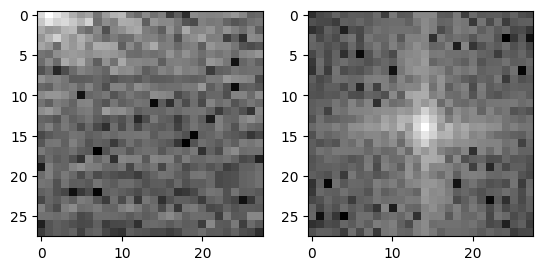

In [5]:
def spiral_matrix(matrix):
    # if not matrix:
    #     return []
    
    result = []
    n = len(matrix)
    top, bottom, left, right = 0, n - 1, 0, n - 1
    
    while len(result) < n * n:
        # Traverse right
        for i in range(left, right + 1):
            result.append(matrix[top][i])
        top += 1
        
        # Traverse down
        for i in range(top, bottom + 1):
            result.append(matrix[i][right])
        right -= 1
        
        if top <= bottom:
            # Traverse left
            for i in range(right, left - 1, -1):
                result.append(matrix[bottom][i])
            bottom -= 1
        
        if left <= right:
            # Traverse up
            for i in range(bottom, top - 1, -1):
                result.append(matrix[i][left])
            left += 1
    
    return torch.tensor(result[::-1])

def rearrange_matrix(original_matrix, patch_size=7):
    """
    Input: The centered fourier Spectrum of a matrix:
    Output: rearranged patches
    """
    # Step 1: Transform the matrix using the spiral method
    flattened = spiral_matrix(original_matrix)
    
    # Step 2: Calculate dimensions
    n = len(original_matrix)
    total_elements = n * n
    patches_per_row = n // patch_size
    
    # Step 3: Create patches
    patches = []
    for i in range(0, total_elements, patch_size * patch_size):
        patch = torch.tensor(flattened[i:i + patch_size * patch_size])
        patch = patch.reshape(patch_size, patch_size)
        patches.append(patch)
    
    # Step 4: Rearrange patches
    result = torch.zeros((n, n), dtype=torch.complex64)
    for i in range(patches_per_row):
        for j in range(patches_per_row):
            patch_index = i * patches_per_row + j
            row_start = i * patch_size
            col_start = j * patch_size
            result[row_start:row_start + patch_size, col_start:col_start + patch_size] = patches[patch_index]
    
    return result

matrix = [
    [1,  2,  3,  4,  5, 123, 1],
    [6,  7,  8,  9,  10, 200, 1],
    [11, 12, 13, 14, 15, 300,1 ],
    [16, 17, 18, 19, 20, 500,1 ],
    [21, 22, 23, 24, 25, 1000,1 ],
    [210,12, 22, 22, 252,1000,1 ],
    [210,12, 22, 22, 252,1000,1]
]

result = spiral_matrix(matrix)
print(result)



# Example usage
data = torch.tensor(train_fft[0][1])
print(f"Data Middle: {data[14,14]}")
print(f"Top left: {data[0,0]}")
result = rearrange_matrix(torch.fft.fftshift(data))

print(result.shape)  # Should be (28, 28)
print(f"result middle {result[27,27]}")
plt.subplot(1,2,1)
plt.imshow(np.log(np.abs(result)), cmap="gray")
plt.subplot(1,2,2)
plt.imshow(np.log(np.abs(np.fft.fftshift(data))), cmap="gray")

1.0 0.0 (299.0078472062014+0j) (-105.1554452474781-85.19899857776973j)


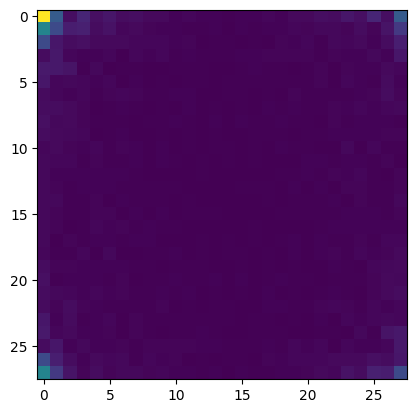

In [6]:
plt.imshow(np.abs(train_fft[0])[1])
print(train_fft[0][0].max(), train_fft[0][0].min(), train_fft[0][1].max(), train_fft[0][1].min())

In [7]:
def phase_shift_fourier(fourier_image, x=2.0, y=2.0):
    """
    Perform a random phase shift on a Fourier-image, constrained by maximum values.
    
    Parameters:
    fourier_image (torch.tensor): Complex-valued centered Fourier representation of an image
    x (float): Maximum amount to shift in x direction (0-2 range recommended due to 2pi periodicity)
    y (float): Maximum amount to shift in y direction (0-2 range recommended due to 2pi periodicity)
    
    Returns:
    torch.tensor: The phase-shifted Fourier-image
    """
    fourier_image = torch.fft.fftshift(fourier_image)
    rows, cols = fourier_image.shape
    
    # Generate random shift amounts within the specified ranges
    random_x = torch.rand(1).item() * x
    random_y = torch.rand(1).item() * y
    shift_x = random_y * torch.pi * rows
    shift_y = random_x * torch.pi * cols
    
    freq_x = torch.fft.fftfreq(cols)
    freq_y = torch.fft.fftfreq(rows)
    fx, fy = torch.meshgrid(freq_x, freq_y, indexing='ij')
    
    # Calculate and apply phase shift
    phase_shift = torch.exp(-1j * (shift_x * fx + shift_y * fy))
    shifted_fourier_image = torch.fft.fftshift(fourier_image * phase_shift)
    
    return shifted_fourier_image


def mask_frequency_spectrum(spectrum, max_mask_percentage):
    # Ensure the max_mask_percentage is between 0 and 100
    max_mask_percentage = torch.clamp(torch.tensor(max_mask_percentage), 0, 100)
    
    # Generate a random mask percentage
    mask_percentage = torch.rand(1) * max_mask_percentage
    
    # Calculate the number of elements to mask
    num_elements = spectrum.numel()
    num_masked = int(num_elements * mask_percentage.item() / 100)
    
    # Create a flat copy of the spectrum
    flat_spectrum = spectrum.view(-1)
    
    # Randomly select indices to mask
    mask_indices = torch.randperm(num_elements)[:num_masked]
    
    # Create a mask tensor
    mask = torch.ones_like(flat_spectrum, dtype=torch.bool)
    mask[mask_indices] = False
    
    # Apply the mask
    masked_spectrum = flat_spectrum.clone()
    masked_spectrum[~mask] = 0
    
    # Reshape the spectrum back to its original shape
    masked_spectrum = masked_spectrum.view(spectrum.shape)
    
    return masked_spectrum


def normalize_magn(fft):
        magnitude = torch.abs(fft)
        phase = torch.angle(fft)
        
        # Normalize magnitude to [0, 1] range
        magnitude_min = torch.min(magnitude)
        magnitude_max = torch.max(magnitude)
        normalized_magnitude = (magnitude - magnitude_min) / (magnitude_max - magnitude_min)
        
        # Rebuild complex number using normalized magnitude and original phase
        normalized_fft = normalized_magnitude * torch.exp(1j * phase)
        
        return normalized_fft

In [8]:
class CustomTransform:
    def __init__(self, is_training=True):
        self.is_training = is_training
        
    def __call__(self, sample):
        img, fft = torch.tensor(np.array(sample))
        if self.is_training: 
            fft = torch.fft.fftshift(fft)
            fft = phase_shift_fourier(fft)
            fft = mask_frequency_spectrum(fft, 75)
            fft_rearranged = rearrange_matrix(fft) # rearrange for better patch awarness
            fft_uncentered = torch.fft.fftshift(fft)
            fft = normalize_magn(fft_rearranged)
            img = torch.fft.ifft2(fft_uncentered)
        # Split the complex image into real and imaginary parts
        img_real = torch.real(img)
        img_imag = torch.imag(img)
        
        # Stack the real and imaginary parts of the image
        img_stacked = torch.stack([img_real, img_imag])
        # Split the complex FFT into real and imaginary parts
        fft_real = torch.real(fft)
        fft_imag = torch.imag(fft)
        fft_stacked = torch.stack([fft_real, fft_imag])
        
        # Stack the image and FFT side by side
        combined = torch.concatenate([img_stacked, fft_stacked], axis=2)
        
        return combined.float()


In [9]:
class ComplexDataset(Dataset):
    def __init__(self, data, labels, is_training=True):
        self.data = data
        self.labels = labels
        self.transform = CustomTransform(is_training)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        sample = self.transform(sample)
        return sample, label

In [10]:
# Create the custom dataset
train_labels = [label for _, label in train_data]
train_dataset = ComplexDataset(train_fft, train_labels, is_training=True)

test_labels = [label for _, label in test_data]
test_dataset = ComplexDataset(test_fft, test_labels, is_training=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(len(train_loader))

938


In [11]:
item = next(iter(train_loader))

/tmp/ipykernel_5760/3847035816.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  patch = torch.tensor(flattened[i:i + patch_size * patch_size])


torch.Size([64, 2, 28, 56])


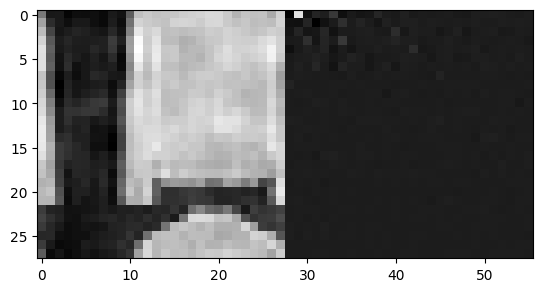

In [12]:
print(item[0].shape)
plt.imshow(item[0][0,0,:,:], cmap="gray")

In [13]:
print(item[0][0][0][0].dtype)

torch.float32


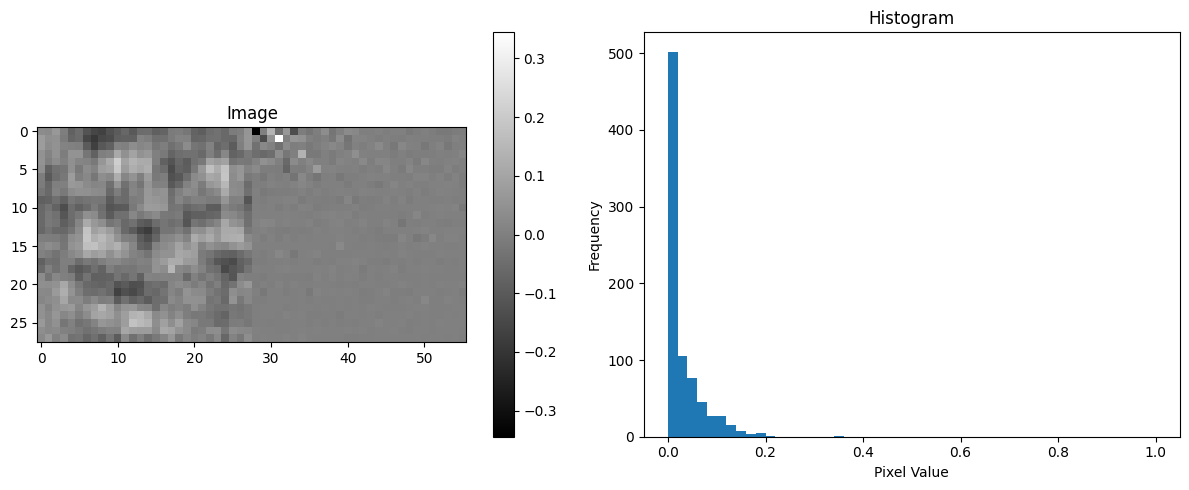

In [14]:

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the image
im = ax1.imshow(item[0][0,1,:,:], cmap="gray")
ax1.set_title("Image")
fig.colorbar(im, ax=ax1)

# Plot the histogram
ax2.hist(item[0][0,1,:,:].ravel(), bins=50, range=(0, 1))
ax2.set_title("Histogram")
ax2.set_xlabel("Pixel Value")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [15]:
model = ViT(
    image_size = 56,
    patch_size = 7,
    num_classes = 10,
    dim = 256,
    depth = 6,
    heads = 12,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1,
    channels = 2
)

img = torch.randn(1, 2, 28, 56)

preds = model(img) # (1, 1000)

In [16]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 6349774


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [18]:
writer = SummaryWriter('runs/experiment_1') 

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}", unit="batch")
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        progress_bar.set_postfix({"Train Loss": train_loss / (batch_idx + 1), "Train Acc": 100. * correct / total})
        
        # Log batch-level metrics
        writer.add_scalar('Loss/Train Batch', loss.item(), epoch * len(train_loader) + batch_idx)
        writer.add_scalar('Accuracy/Train Batch', 100. * correct / total, epoch * len(train_loader) + batch_idx)
    
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total
    
    # Log epoch-level metrics
    writer.add_scalar('Loss/Train Epoch', train_loss, epoch)
    writer.add_scalar('Accuracy/Train Epoch', train_accuracy, epoch)
    
    return train_loss, train_accuracy

def test(model, device, test_loader, criterion, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total
    
    # Log epoch-level metrics
    writer.add_scalar('Loss/Test', test_loss, epoch)
    writer.add_scalar('Accuracy/Test', test_accuracy, epoch)
    
    return test_loss, test_accuracy


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [29]:

epochs = 1000
for epoch in range(0, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion, epoch)
    test_loss, test_accuracy = test(model, device, test_loader, criterion, epoch)
    print(f"Epoch {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print()


writer.close()

Epoch 0:   0%|          | 0/938 [00:00<?, ?batch/s]/tmp/ipykernel_5760/3847035816.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  patch = torch.tensor(flattened[i:i + patch_size * patch_size])
Epoch 0: 100%|██████████| 938/938 [02:14<00:00,  6.97batch/s, Train Loss=0.665, Train Acc=75.6]


Epoch 0
Train Loss: 0.6652, Train Accuracy: 75.58%
Test Loss: 0.5124, Test Accuracy: 81.44%



Epoch 1: 100%|██████████| 938/938 [02:17<00:00,  6.83batch/s, Train Loss=0.66, Train Acc=75.5] 


Epoch 1
Train Loss: 0.6597, Train Accuracy: 75.47%
Test Loss: 0.5207, Test Accuracy: 80.86%



Epoch 2: 100%|██████████| 938/938 [02:03<00:00,  7.61batch/s, Train Loss=0.65, Train Acc=75.9] 


Epoch 2
Train Loss: 0.6503, Train Accuracy: 75.88%
Test Loss: 0.5408, Test Accuracy: 80.16%



Epoch 3: 100%|██████████| 938/938 [02:04<00:00,  7.56batch/s, Train Loss=0.64, Train Acc=76.3] 


Epoch 3
Train Loss: 0.6405, Train Accuracy: 76.27%
Test Loss: 0.5056, Test Accuracy: 81.56%



Epoch 4: 100%|██████████| 938/938 [02:01<00:00,  7.71batch/s, Train Loss=0.637, Train Acc=76.3]


Epoch 4
Train Loss: 0.6369, Train Accuracy: 76.33%
Test Loss: 0.4666, Test Accuracy: 82.86%



Epoch 5: 100%|██████████| 938/938 [02:02<00:00,  7.65batch/s, Train Loss=0.627, Train Acc=77]  


Epoch 5
Train Loss: 0.6271, Train Accuracy: 76.96%
Test Loss: 0.5011, Test Accuracy: 81.77%



Epoch 6: 100%|██████████| 938/938 [02:03<00:00,  7.60batch/s, Train Loss=0.619, Train Acc=77.2]


Epoch 6
Train Loss: 0.6185, Train Accuracy: 77.18%
Test Loss: 0.4856, Test Accuracy: 82.24%



Epoch 7: 100%|██████████| 938/938 [02:01<00:00,  7.71batch/s, Train Loss=0.61, Train Acc=77.4] 


Epoch 7
Train Loss: 0.6096, Train Accuracy: 77.41%
Test Loss: 0.4944, Test Accuracy: 81.98%



Epoch 8: 100%|██████████| 938/938 [02:02<00:00,  7.66batch/s, Train Loss=0.603, Train Acc=77.7]


Epoch 8
Train Loss: 0.6031, Train Accuracy: 77.72%
Test Loss: 0.5157, Test Accuracy: 81.18%



Epoch 9: 100%|██████████| 938/938 [02:03<00:00,  7.59batch/s, Train Loss=0.592, Train Acc=78.2]


Epoch 9
Train Loss: 0.5923, Train Accuracy: 78.15%
Test Loss: 0.4710, Test Accuracy: 82.39%



Epoch 10: 100%|██████████| 938/938 [02:02<00:00,  7.65batch/s, Train Loss=0.592, Train Acc=78.2]


Epoch 10
Train Loss: 0.5916, Train Accuracy: 78.19%
Test Loss: 0.4504, Test Accuracy: 83.29%



Epoch 11: 100%|██████████| 938/938 [02:00<00:00,  7.77batch/s, Train Loss=0.586, Train Acc=78.4]


Epoch 11
Train Loss: 0.5861, Train Accuracy: 78.39%
Test Loss: 0.4600, Test Accuracy: 82.94%



Epoch 12: 100%|██████████| 938/938 [02:01<00:00,  7.72batch/s, Train Loss=0.577, Train Acc=78.7]


Epoch 12
Train Loss: 0.5773, Train Accuracy: 78.67%
Test Loss: 0.4501, Test Accuracy: 83.52%



Epoch 13: 100%|██████████| 938/938 [02:07<00:00,  7.36batch/s, Train Loss=0.572, Train Acc=78.9]


Epoch 13
Train Loss: 0.5719, Train Accuracy: 78.92%
Test Loss: 0.4584, Test Accuracy: 82.81%



Epoch 14: 100%|██████████| 938/938 [02:03<00:00,  7.59batch/s, Train Loss=0.568, Train Acc=78.9]


Epoch 14
Train Loss: 0.5683, Train Accuracy: 78.94%
Test Loss: 0.4339, Test Accuracy: 83.81%



Epoch 15: 100%|██████████| 938/938 [02:04<00:00,  7.54batch/s, Train Loss=0.559, Train Acc=79.1]


Epoch 15
Train Loss: 0.5585, Train Accuracy: 79.12%
Test Loss: 0.4245, Test Accuracy: 84.51%



Epoch 16: 100%|██████████| 938/938 [02:05<00:00,  7.46batch/s, Train Loss=0.559, Train Acc=79.2]


Epoch 16
Train Loss: 0.5593, Train Accuracy: 79.25%
Test Loss: 0.4363, Test Accuracy: 83.73%



Epoch 17: 100%|██████████| 938/938 [02:06<00:00,  7.40batch/s, Train Loss=0.555, Train Acc=79.4]


Epoch 17
Train Loss: 0.5550, Train Accuracy: 79.36%
Test Loss: 0.4222, Test Accuracy: 84.58%



Epoch 18: 100%|██████████| 938/938 [02:04<00:00,  7.54batch/s, Train Loss=0.549, Train Acc=79.5]


Epoch 18
Train Loss: 0.5485, Train Accuracy: 79.52%
Test Loss: 0.4311, Test Accuracy: 84.12%



Epoch 19: 100%|██████████| 938/938 [02:09<00:00,  7.26batch/s, Train Loss=0.539, Train Acc=80.1]


Epoch 19
Train Loss: 0.5392, Train Accuracy: 80.09%
Test Loss: 0.4307, Test Accuracy: 84.29%



Epoch 20: 100%|██████████| 938/938 [02:04<00:00,  7.51batch/s, Train Loss=0.543, Train Acc=79.9]


Epoch 20
Train Loss: 0.5433, Train Accuracy: 79.92%
Test Loss: 0.4099, Test Accuracy: 84.94%



Epoch 21: 100%|██████████| 938/938 [02:05<00:00,  7.50batch/s, Train Loss=0.534, Train Acc=80.2]


Epoch 21
Train Loss: 0.5341, Train Accuracy: 80.23%
Test Loss: 0.3928, Test Accuracy: 85.50%



Epoch 22:   9%|▉         | 83/938 [00:11<01:56,  7.32batch/s, Train Loss=0.518, Train Acc=80]  


KeyboardInterrupt: 

In [30]:
def save_model(model, optimizer, epoch, loss, accuracy, filename):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy
    }, filename)


In [31]:
save_model(model, optimizer, epochs, test_loss, test_accuracy, 'final_model_epochxx.pth')

In [28]:
def load_model(model, optimizer, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    accuracy = checkpoint['accuracy']
    return model, optimizer, epoch, loss, accuracy

# Usage
model, optimizer, epoch, loss, accuracy = load_model(model, optimizer, 'final_model_epoch19.pth')
model = model.to(device)